In [ ]:
import numpy as np
import pandas as pd 
import os
%matplotlib inline
import matplotlib.pyplot as plt
import os
from scipy.io import wavfile
from collections import defaultdict, Counter
from scipy import signal
import numpy as np
import librosa
import random as rn
import tensorflow as tf
from tensorflow import keras
import warnings
warnings.filterwarnings("ignore")

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
# FSDD
#!git clone https://github.com/Jakobovski/free-spoken-digit-dataset.git


In [ ]:
FSDD_baseline = 92.00
FSDD_accuracies = np.array([94.5,94.83,92.50,92.50,97.33,97.83,93.00,96.5,92.16 ])

def get_weights(accuracies, baseline):
  diff = accuracies - baseline
  sum_diff = np.sum(diff)
  weights = diff / sum_diff
  return weights

def Weighted_AudioRandAug(N, M, Weights):
  # Generate the best possible set of data aumgentation based on weigths 
  # Parameters:
  #  N (Integer) :   Number of the data augmentations  
  #  M (List)    :   List of best magnitudes of data augmentation    
  # Weights(list):   Weights of each augmentation
  
  augmentations = ["Noise Injection", "Pitch Shifting","Time Stretching",
                  "Padding","Clip","Reverse","Band Pass Filter",
                  "Gain", "Time Mask"]

  selected_augmentations = np.random.choice(augmentations, N, p = Weights)
  # print(selected_augmentations)
  idxs = [augmentations.index(i) for i in selected_augmentations]
  select_mag = [M[i] for i in idxs]

  return [(aug, m) for (m,aug) in zip(select_mag, selected_augmentations)]

def Non_Weighted_AudioRandAug(N, M):
    # Generate the best possible set of data aumgentation
  # Parameters:
  #  N (Integer) :   Number of the data augmentations  
  #  M (List)    :   List of best magnitudes of data augmentation  


  augmentations = ["Noise Injection", "Pitch Shifting","Time Stretching",
                  "Padding","Clip","Reverse","Band Pass Filter",
                  "Gain", "Time Mask"]
  
  
  selected_augmentations = np.random.choice(augmentations, N)
  idxs = [augmentations.index(i) for i in selected_augmentations]
  select_mag = [M[i] for i in idxs]
  
  return [(aug, m) for (m,aug) in zip(select_mag, selected_augmentations)]


In [ ]:
!pip install audiomentations


In [ ]:
# Weighted AudRandAug experiments
M = [0.015,4.0,1.4,1.0,0.7,1.0,18,12,0.5]
N = 2 # no of augmentations
augs = Weighted_AudioRandAug(N, M, weights)
augs[0]=(augs[0][0],6.2)
print(augs[0])

('Time Stretching', 6.2)


In [ ]:
from typing import List
from audiomentations import Compose, AddGaussianNoise, TimeStretch, PitchShift, Shift, Clip, Padding, Reverse, Trim, BandPassFilter, BandStopFilter,Gain,TimeMask

def get_augs(augs:list):
  augmentations = []
  for augm in augs:
    aug = augm[0]
    mag = augm[1]
    if aug == 'Noise Injection':
        augmentations.append(AddGaussianNoise(min_amplitude=0.001, max_amplitude=mag, p=1.0))
    elif aug == 'Pitch Shifting':
        augmentations.append(PitchShift(min_semitones=-4, max_semitones=mag, p=1.0))
    elif aug == 'Time Stretching':
        augmentations.append(TimeStretch(min_rate=0.5, max_rate=mag, p=1.0))
    elif aug == 'Clip':
        augmentations.append(Clip( a_min=-1.0, a_max=mag, p=1.0))
    elif aug == 'Padding':
        augmentations.append(Padding(min_fraction=0.1,max_fraction=mag, p=1.0))
    elif aug == 'Reverse':
        augmentations.append(Reverse(p=1.0))
    elif aug == 'Band Pass Filter':
        augmentations.append(BandPassFilter(min_rolloff=12,max_rolloff=mag, p=1.0))
    elif aug == 'Gain':
      augmentations.append(Gain(min_gain_in_db=-12, max_gain_in_db=mag,p=1.0))
    elif aug == 'Time Mask':
      augmentations.append(TimeMask(min_band_part=0.1, max_band_part=mag,p=1.0))
  return augmentations

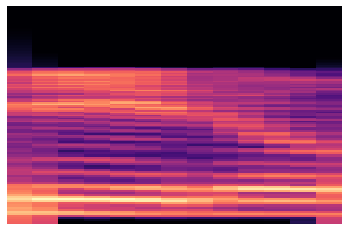

In [ ]:
import librosa.display

y, sr = librosa.load('/content/free-spoken-digit-dataset/recordings/0_george_0.wav')

fig, ax = plt.subplots()
plt.axis('off')
M = librosa.feature.melspectrogram(y=y, sr=sr)
M_db = librosa.power_to_db(M, ref=np.max)
img = librosa.display.specshow(M_db, y_axis='mel', x_axis='time', ax=ax)

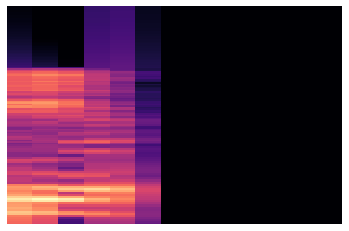

In [ ]:
augment = Compose(get_augs(augs))
wav = augment(samples=y, sample_rate=sr)

fig, ax = plt.subplots()
plt.axis('off')
M = librosa.feature.melspectrogram(y=wav, sr=sr)
M_db = librosa.power_to_db(M, ref=np.max)
img = librosa.display.specshow(M_db, y_axis='mel', x_axis='time', ax=ax)

In [ ]:
def CalculateMFCC(y, sr):
  melSpec = librosa.feature.mfcc(y=y, sr=sr)
  dim = (32, 32)
  resized = cv2.resize(melSpec, dim, interpolation = cv2.INTER_AREA)
  return resized

selected_augs = get_augs(augs)

In [ ]:
import os
import cv2

x,y=[],[]

count = 0
import matplotlib.pyplot as plt

for fname in os.listdir(DATA_DIR):
  try:
    if '.wav' not in fname or 'dima' in fname:
      continue
    struct = fname.split('_')
    digit = struct[0]
    speaker = struct[1]
    wav, sr = librosa.load(DATA_DIR + fname)
    augment = Compose(get_augs(augs))
    wav = augment(samples=wav, sample_rate=sr)
    #mel = librosa.feature.melspectrogram(y=wav, sr=sr)
    #mel = cv2.resize(librosa.power_to_db(mel, ref=np.max), (225, 225, 1))
    mel = CalculateMFCC(wav, sr)
    x.append(mel)
    y.append(int(digit))
  except:
    # nothing
    count=0


In [ ]:
len(x)

3000

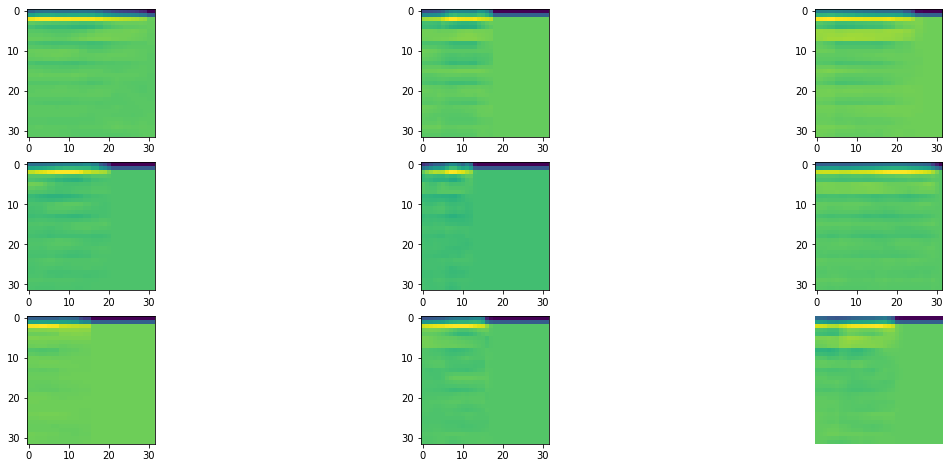

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(20, 8))
columns = 3
rows = 3
for i in range(1, columns*rows +1):
    img = x[i]
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
plt.axis('off')    
plt.show()

In [ ]:
from sklearn.model_selection import train_test_split


x = np.array(x)
y = tf.keras.utils.to_categorical(np.array(y))

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)


In [ ]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)


(2400, 32, 32)
(2400, 10)
(600, 32, 32)
(600, 10)


In [ ]:
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2], 1)

In [ ]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(2400, 32, 32, 1)
(2400, 10)
(600, 32, 32, 1)
(600, 10)


In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint


model = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(32, (3,3), activation='relu',
                         kernel_regularizer=tf.keras.regularizers.l2(0.002), 
                         input_shape=(32, 32, 1)),
  tf.keras.layers.MaxPooling2D(2, 2),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Conv2D(64, (1,1), activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.002)),
  tf.keras.layers.MaxPooling2D(2,2),
#   tf.keras.layers.Conv2D(64, (1,1), activation=tf.keras.layers.LeakyReLU()),
#   tf.keras.layers.MaxPooling2D(2,2),  
#   tf.keras.layers.Dropout(0.1),  
    
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(64, activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.002)),
  tf.keras.layers.Dense(10, activation='softmax')
])
model.compile(optimizer = 'adam',
              loss = 'categorical_crossentropy',metrics=['accuracy'])

callbacks = ModelCheckpoint("model.h5", monitor='val_accuracy',
                                    mode='max',
                                    save_best_only=True,
                                    verbose=1)
# model.fit(train_X, train_y, epochs=5,verbose =1)
history = model.fit(x_train,
          y_train,
          epochs=100,
          batch_size=64,
          validation_data=(x_test, y_test), verbose = 1, callbacks=[callbacks])

Epoch 1/100
36/38 [===========================>..] - ETA: 0s - loss: 11.8956 - accuracy: 0.1849
Epoch 1: val_accuracy improved from -inf to 0.29333, saving model to model.h5
38/38 [==============================] - 1s 11ms/step - loss: 11.5550 - accuracy: 0.1925 - val_loss: 2.7523 - val_accuracy: 0.2933
Epoch 2/100
36/38 [===========================>..] - ETA: 0s - loss: 2.9269 - accuracy: 0.3368
Epoch 2: val_accuracy improved from 0.29333 to 0.42667, saving model to model.h5
38/38 [==============================] - 0s 6ms/step - loss: 2.9057 - accuracy: 0.3413 - val_loss: 1.8527 - val_accuracy: 0.4267
Epoch 3/100
35/38 [==========================>...] - ETA: 0s - loss: 2.0885 - accuracy: 0.4786
Epoch 3: val_accuracy improved from 0.42667 to 0.61167, saving model to model.h5
38/38 [==============================] - 0s 7ms/step - loss: 2.0760 - accuracy: 0.4783 - val_loss: 1.3583 - val_accuracy: 0.6117
Epoch 4/100
35/38 [==========================>...] - ETA: 0s - loss: 1.6801 - accurac

In [ ]:
from sklearn.metrics import accuracy_score
from keras.models import load_model
model = load_model('model.h5')
print("Test Accuracy is ", model.evaluate(x_test, y_test)[1])

19/19 [==============================] - 0s 3ms/step - loss: 0.4665 - accuracy: 0.9250
Test Accuracy is  0.925000011920929


In [ ]:
hist_df = pd.DataFrame(history.history) 
modelName="padding"
hist_df.to_csv("/content/drive/MyDrive/AICS-paper/NEW/"+modelName+".csv")
# save model
model.save('/content/drive/MyDrive/AICS-paper/NEW/'+modelName+'.h5')

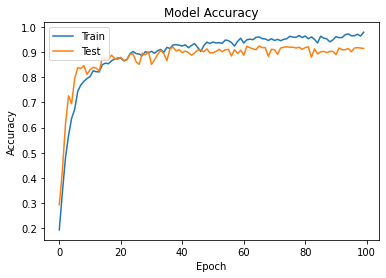

In [ ]:
plt.style.use("ggplot")
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
np.save(model)